# SQL

Для выполнения тестового задания была спроектирована небольшая база данных на MySQL 8.0. 

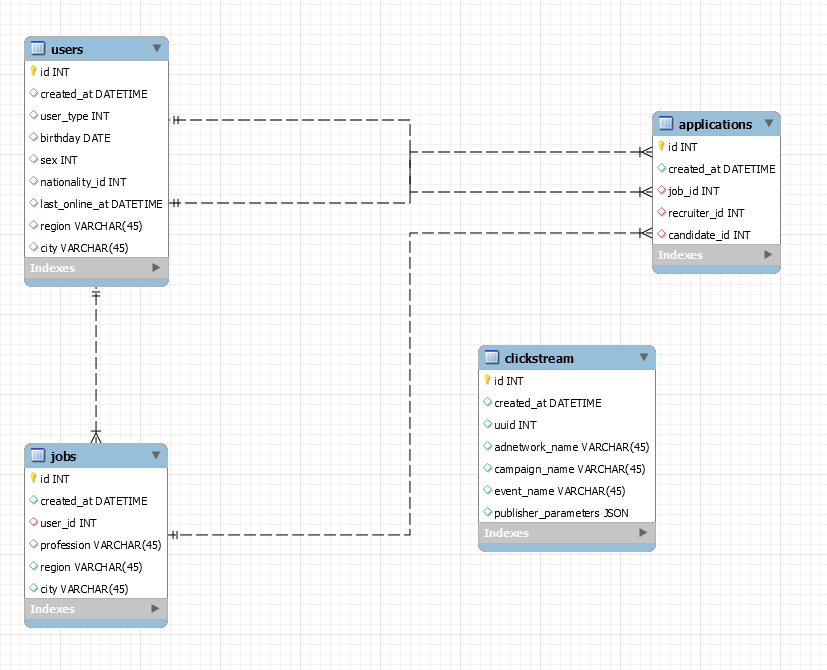

Таблицы спроектированы по ТЗ. 
Таблица **users** является местом хранения информации о пользователях и имеет первичный ключ *id*. 
Таблица **jobs** является местом хранения информации о вакансиях и имеет первичный ключ *id*, а также внешний ключ *user_id*, являющийся ссылкой к *users.id*. 
Таблица **applications** является местом хранения информации об откликах на вакансии и имеет первичный ключ *id*, а также внешние ключи *job_id* (ссылка на *jobs.id*), *recruiter_id*, *candidate_id* (ссылка на *users.id*).
Таблица **clickstream** учитывает статистику действий пользователей и не имеет внешних ключей.

Для проверки запросов таблицы заполнены следующими тестовыми данными (см. ниже).

### Таблица users

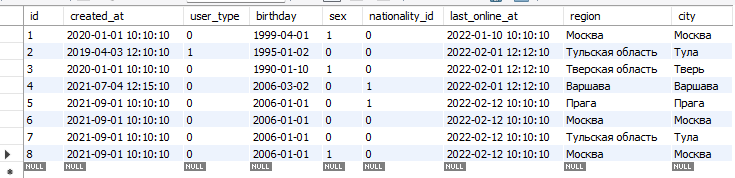

Для всех вакансий будет использоваться один рекрутер. Это не повлияет на логику бизнес-процесса тестового задания.

### Таблица jobs

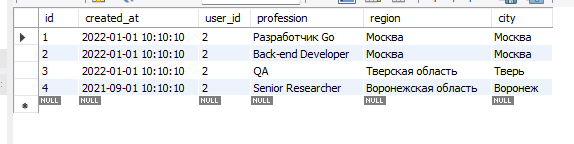

### Таблица applications

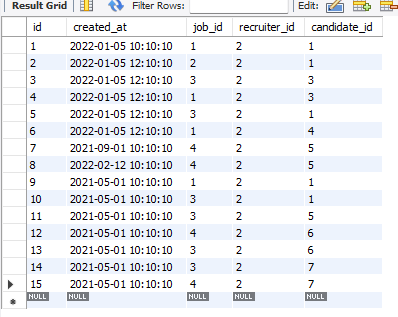

### Таблица clickstream

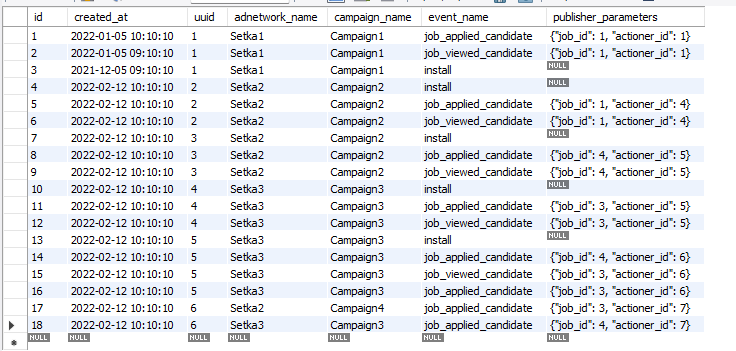

На этапе построения таблицы **clickstream** использовались некоторые допущения, засчет того, что логика бизнес-процесса была не до конца понятна из описания. В качестве *uuid* использовались уникальные значения, не соотносящиеся с таблицей *users*, а некоторые уникальные значения пользователей (например, создание новой пользовательской сессии создает новое уникальное *uuid*). Имена для *adnetwork_name* и *campaign_name* выбраны для удобства проверки запросов.

#### Какой процент кандидатов хотя бы раз откликался на вакансию? 

Для выполнения запроса требуется найти отношение количества пользователей, имеющих хотя бы один отклик к общему количеству пользователей. Для более точного выполнения логики бизнес-процесса не учитывались рекрутеры, т. е., пользователи, чьи *users.user_type = 1*.

Из спроектированного примера, посмотрев в таблицу **applications**, отклики сделали все пользователи, кроме последнего, т. е. 6 из 7 кандидатов и ожидаемый результат $6/7 * 100\% \approx 85.71\%$.

С помощью подзапроса, используя левостороннее соединение, объединяются таблицы **users** и **applications** и в качестве условия для отбора тех, кто сделал отклик выбирается то, что любое поле из таблицы **applications** не NULL-значение (засчет LEFT JOIN) и *users.user_type = 0*. С помощью COUNT() ищется количество "уникальных" откликов (т. е., если пользователь делал, к примеру, 5 откликов, пользователь будет учитываться один раз). Результатом подзапроса будет количество уникальных откликов (в примере - 6). Из полученного подзапроса с помощью деления вычисляется необходимый процент.

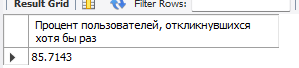

#### Доля откликов на вакансии, находящиеся в разных регионах

Для выполнения запроса требуется найти отношение откликов из других регионов к общему количеству откликов. 

Для реализации запроса требуется обратиться к таблице **applications**, содержащую информацию об откликах. Для того, чтобы узнать регион вакансии и регион кандидата, необходимо произвести соединение нескольких таблиц: **applications**, **jobs**, **users** по соответствующим внешним ключам. После выполнения соединения оставляем строки, где *users.region != jobs.region*.

Из данного подзапроса вычислим количество откликов из других запросов с помощью COUNT(). Общее количество откликов вычислим с помощью COUNT() для таблицы **applications** без каких-либо условий. Результат - отношение второй величины к первой. 

Ожидаемый результат для спроектированной таблицы: всего откликов - 15, откликов из других регионов - 11 (см. ниже запрос на изображении, примечание: запрос на изображении не является результирующим, а лишь поясняет значение "откликов из других регионов" для примера). Отношение (процент): $11/15 * 100\% \approx 73.33 \%$.
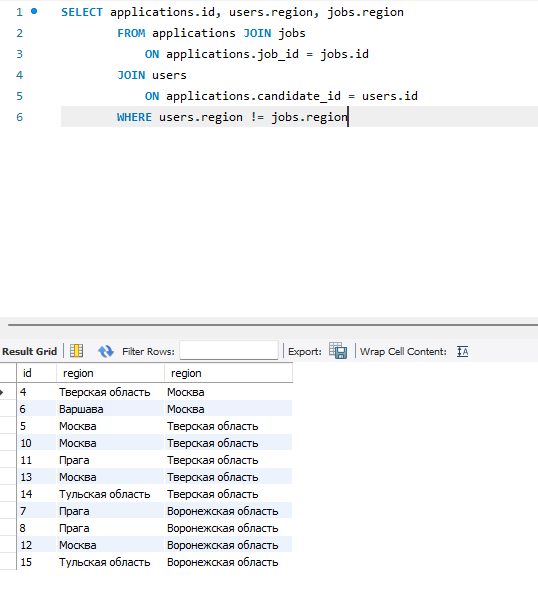

Результирующий запрос для ответа на вопрос представлен ниже.

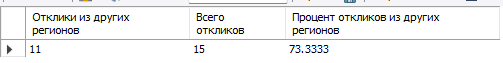

#### Процент пользователей среди откликавшихся сделал второй отклик на профессию, отличную от профессии первого отклика

Для выполнения запроса сначала выполним подзапрос, который группирует отклики пользователей на вакансии с их идентификатором. Это необходимо для того, чтобы отсеять несколько откликов одного пользователя на одну и ту же вакансию.


Из подзапроса посчитаем количество откликов каждого пользователя на другие вакансии с помощью COUNT(). Для подсчета результирующего отношения будем считать количество пользователей со вторым или более откликом на другую вакансию как SUM(COUNT() > 1), чтобы учитывать количество пользователей, а не количество откликов.

Результирующий запрос представлен ниже.

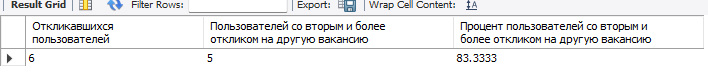

#### Количество пользователей, которые вернулись через 3 месяца после первого отклика и сделали повторный

Для выполнения запроса необходимо выяснить, когда был предыдущий отклик данного пользователя на данную вакансию. Также необходимо учесть ситуацию, когда откликов на одну и ту же вакансию с интервалом в три месяца может быть вовсе 3 и более.

С помощью условия CASE WHEN проверим условие с помощью функции TIMESTAMPDIFF и оконной функции LAG на то, что между датой и предыдущей датой как минимум 3 месяца. При выполнении условия в строке ставится 1, при невыполнении - 0. Строки с нулями не будут рассматриваться далее.

Из полученного подзапроса выбираются уникальные идентификаторы пользователей и считается их количество. В результате будет учтена ситуация, когда откликов на одну и ту же вакансию 3 и более.

Результирующий запрос представлен ниже.

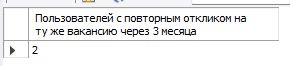

#### Рекламная сетка, которая льет больше всего несовершеннолетних девушек из РФ

Примем логику бизнес-процесса запроса как "найти уникальных пользователей-девушек с возрастом меньше 18 лет в каждой сетке, которые совершили действие (только отклик(!): действие "просмотр вакансии" не учитывается как "вклад" в метрику, но легко добавляется в запрос)".

С помощью подзапроса сделаем выборку вида "имя сетки" (*clickstream.adnetwork_name*), "идентификатор пользователя, совершившего действие" (*clickstream.publisher_parameters -> "$.actioner_id*), где действие имеет тип "отклик" (*clickstream.event_name = 'job_applied_candidate'*).

Совершим соединение этой выборки с таблицей **users**, чтобы узнать возраст, пол и гражданство откликавшихся. С помощью условия отберем кандидатов (*users.user_type = 0*) девушек (*users.sex = 0*) с гражданством РФ (*users.nationality_id = 0*), которым меньше 18 и произведем группировку для того, чтобы исключить попадание откликов одного и того же пользователя одной сетки дважды.

Полученный результат группируем еще раз для нахождения результатов для каждой сетки. Сортируем по убыванию и берем самый большой результат.

Результирующий запрос представлен ниже.

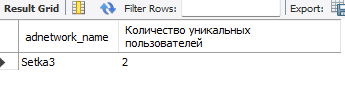

*Примечание:* стоило бы учесть вариант, когда две сетки могут иметь одинаковое максимальное количество уникальных пользователей. В таком случае, стоит добавить оконную функцию RANK_NUMBER() и выбрать строки, где RANK_NUMBER() = 1.

# Python

#### Очистка данных

После загрузки и попытки открытия csv через pandas, было обнаружено, что на данных сбита кодировка, поэтому была проведена конвертация и небольшое первичное преобразование данных. Через Microsoft Excel сменена кодировка на UTF-8, csv преобразован в xlsx, а столбцы датасета осмысленно названы исходя из описания по одной из открывшихся ссылок.

In [1]:
import pandas as pd
data = pd.read_excel("dataset_correct.xlsx")
data.head()

id     price                                features  \
0   0  13700000    \n 2-к квартира, 65 м², 13/25 эт.\n    
1   1   7912000      \n 2-к квартира, 43 м², 2/5 эт.\n    
2   2   9390000   \n 2-к квартира, 52.2 м², 4/17 эт.\n    
3   3   8667975  \n 2-к квартира, 59.3 м², 13/25 эт.\n    
4   4   9180000  \n 2-к квартира, 58.9 м², 13/17 эт.\n    

                                                link  \
0  /moskva/kvartiry/2-k_kvartira_65_m_1325_et._19...   
1  /moskva/kvartiry/2-k_kvartira_43_m_25_et._1425...   
2  /moskva/kvartiry/2-k_kvartira_52.2_m_417_et._2...   
3  /moskva/kvartiry/2-k_kvartira_59.3_m_1325_et._...   
4  /moskva/kvartiry/2-k_kvartira_58.9_m_1317_et._...   

                         street   subway_station to_subway  
0       \n Лукинская ул., 10\n   Новопеределкино    1,3 км  
1    \n 12-я Парковая ул., 5\n      Первомайская     900 м  
2    \n Покровская ул., 17к2\n        Некрасовка     600 м  
3  \n Рождественская ул., 33\n        Некрасовка     200 м  
4       \n ул. Лавриненко, 1\n        Некрасовка     800 м

In [2]:
data.shape

(4293, 7)

Первым делом необходимо убрать символы перевода строки и перевести расстояние до метро к единой системе измерения.

In [3]:
replace_candidates = ['features', 'street']
data[replace_candidates] = data[replace_candidates].replace(to_replace='\n', value='', regex=True)
data.head()

id     price                            features  \
0   0  13700000     2-к квартира, 65 м², 13/25 эт.    
1   1   7912000       2-к квартира, 43 м², 2/5 эт.    
2   2   9390000    2-к квартира, 52.2 м², 4/17 эт.    
3   3   8667975   2-к квартира, 59.3 м², 13/25 эт.    
4   4   9180000   2-к квартира, 58.9 м², 13/17 эт.    

                                                link  \
0  /moskva/kvartiry/2-k_kvartira_65_m_1325_et._19...   
1  /moskva/kvartiry/2-k_kvartira_43_m_25_et._1425...   
2  /moskva/kvartiry/2-k_kvartira_52.2_m_417_et._2...   
3  /moskva/kvartiry/2-k_kvartira_59.3_m_1325_et._...   
4  /moskva/kvartiry/2-k_kvartira_58.9_m_1317_et._...   

                     street   subway_station to_subway  
0        Лукинская ул., 10   Новопеределкино    1,3 км  
1     12-я Парковая ул., 5      Первомайская     900 м  
2     Покровская ул., 17к2        Некрасовка     600 м  
3   Рождественская ул., 33        Некрасовка     200 м  
4        ул. Лавриненко, 1        Некрасовка     800 м

Чтобы привести данные к единой системе измерения (метры), выведем данные из первой строки, чтобы понять, как разделить ее далее.

In [4]:
example = data['to_subway'][0]
example

' 1,3\xa0км'

Заметим, что перед числом стоит пробел, а сами единицы разделены неразрывным пробелом \xa0. Также для преобразования к числовому виду, необходимо заменить запятую на точку: именно так Python воспринимает числа с плавающей точкой. *Важно также не забыть, что некоторые данные в столбце могут быть пустыми.*

In [5]:
example = data['to_subway'][0]
float(example.split('\xa0')[0].split()[0].replace(',', '.'))

1.3

In [6]:
example = data['to_subway'][0]
example.split('\xa0')

[' 1,3', 'км']

In [7]:
def to_meters(string):
    string = str(string)
    result = string.split('\xa0')
    if result[0] == 'nan':
        return 'NaN'
    elif result[1] == 'м':
        return float(result[0].split()[0])
    else:
        return float(result[0].split()[0].replace(',', '.')) * 1000
data['to_subway'] = data['to_subway'].apply(to_meters)
data.head()

id     price                            features  \
0   0  13700000     2-к квартира, 65 м², 13/25 эт.    
1   1   7912000       2-к квартира, 43 м², 2/5 эт.    
2   2   9390000    2-к квартира, 52.2 м², 4/17 эт.    
3   3   8667975   2-к квартира, 59.3 м², 13/25 эт.    
4   4   9180000   2-к квартира, 58.9 м², 13/17 эт.    

                                                link  \
0  /moskva/kvartiry/2-k_kvartira_65_m_1325_et._19...   
1  /moskva/kvartiry/2-k_kvartira_43_m_25_et._1425...   
2  /moskva/kvartiry/2-k_kvartira_52.2_m_417_et._2...   
3  /moskva/kvartiry/2-k_kvartira_59.3_m_1325_et._...   
4  /moskva/kvartiry/2-k_kvartira_58.9_m_1317_et._...   

                     street   subway_station to_subway  
0        Лукинская ул., 10   Новопеределкино    1300.0  
1     12-я Парковая ул., 5      Первомайская     900.0  
2     Покровская ул., 17к2        Некрасовка     600.0  
3   Рождественская ул., 33        Некрасовка     200.0  
4        ул. Лавриненко, 1        Некрасовка     800.0

Удалим все строки, где присутствуют пустые значения. В данном случае нет смысла заменять их на среднее - это исказит результаты.

In [8]:
data = data.dropna()
data

id     price                            features  \
0        0  13700000     2-к квартира, 65 м², 13/25 эт.    
1        1   7912000       2-к квартира, 43 м², 2/5 эт.    
2        2   9390000    2-к квартира, 52.2 м², 4/17 эт.    
3        3   8667975   2-к квартира, 59.3 м², 13/25 эт.    
4        4   9180000   2-к квартира, 58.9 м², 13/17 эт.    
...    ...       ...                                 ...   
4287  4287   8664000    2-к квартира, 65.2 м², 7/25 эт.    
4288  4288   9557050   2-к квартира, 65.4 м², 14/25 эт.    
4289  4289   8667975    2-к квартира, 59.3 м², 5/25 эт.    
4290  4290   8667975    2-к квартира, 59.3 м², 4/25 эт.    
4292  4292  13000000    2-к квартира, 70.3 м², 3/13 эт.    

                                                   link  \
0     /moskva/kvartiry/2-k_kvartira_65_m_1325_et._19...   
1     /moskva/kvartiry/2-k_kvartira_43_m_25_et._1425...   
2     /moskva/kvartiry/2-k_kvartira_52.2_m_417_et._2...   
3     /moskva/kvartiry/2-k_kvartira_59.3_m_1325_et._...   
4     /moskva/kvartiry/2-k_kvartira_58.9_m_1317_et._...   
...                                                 ...   
4287  /moskva/kvartiry/2-k_kvartira_65.2_m_725_et._1...   
4288  /moskva/kvartiry/2-k_kvartira_65.4_m_1425_et._...   
4289  /moskva/kvartiry/2-k_kvartira_59.3_m_525_et._1...   
4290  /moskva/kvartiry/2-k_kvartira_59.3_m_425_et._1...   
4292  /moskva/kvartiry/2-k_kvartira_70.3_m_313_et._1...   

                        street   subway_station to_subway  
0           Лукинская ул., 10   Новопеределкино    1300.0  
1        12-я Парковая ул., 5      Первомайская     900.0  
2        Покровская ул., 17к2        Некрасовка     600.0  
3      Рождественская ул., 33        Некрасовка     200.0  
4           ул. Лавриненко, 1        Некрасовка     800.0  
...                        ...              ...       ...  
4287     ул. Вертолётчиков, 1        Некрасовка     700.0  
4288   Рождественская ул., 33        Некрасовка     200.0  
4289   Рождественская ул., 33        Некрасовка     200.0  
4290   Рождественская ул., 33        Некрасовка     200.0  
4292    Варшавское ш., 141к13            Аннино     600.0  

[4198 rows x 7 columns]

В итоге, удалили 95 строк - что вполне приемлемо для общего количества данных. Удалим также столбец **link**, так как большинство ссылок битые/объявления сняты и столбец не представляет значимости.

In [9]:
data = data.drop(columns=['link'], axis=1)

In [10]:
data

id     price                            features  \
0        0  13700000     2-к квартира, 65 м², 13/25 эт.    
1        1   7912000       2-к квартира, 43 м², 2/5 эт.    
2        2   9390000    2-к квартира, 52.2 м², 4/17 эт.    
3        3   8667975   2-к квартира, 59.3 м², 13/25 эт.    
4        4   9180000   2-к квартира, 58.9 м², 13/17 эт.    
...    ...       ...                                 ...   
4287  4287   8664000    2-к квартира, 65.2 м², 7/25 эт.    
4288  4288   9557050   2-к квартира, 65.4 м², 14/25 эт.    
4289  4289   8667975    2-к квартира, 59.3 м², 5/25 эт.    
4290  4290   8667975    2-к квартира, 59.3 м², 4/25 эт.    
4292  4292  13000000    2-к квартира, 70.3 м², 3/13 эт.    

                        street   subway_station to_subway  
0           Лукинская ул., 10   Новопеределкино    1300.0  
1        12-я Парковая ул., 5      Первомайская     900.0  
2        Покровская ул., 17к2        Некрасовка     600.0  
3      Рождественская ул., 33        Некрасовка     200.0  
4           ул. Лавриненко, 1        Некрасовка     800.0  
...                        ...              ...       ...  
4287     ул. Вертолётчиков, 1        Некрасовка     700.0  
4288   Рождественская ул., 33        Некрасовка     200.0  
4289   Рождественская ул., 33        Некрасовка     200.0  
4290   Рождественская ул., 33        Некрасовка     200.0  
4292    Варшавское ш., 141к13            Аннино     600.0  

[4198 rows x 6 columns]

In [11]:
data.dtypes

id                 int64
price              int64
features          object
street            object
subway_station    object
to_subway         object
dtype: object

После преобразования данных в столбце **to_subway** числа были приведены к типу float только для вычисления произведения (перевод километров в метры), но сами данные для датафрейма все еще воспринимаются как 'object', поэтому произведем преобразование.

In [12]:
data['to_subway'] = data['to_subway'].astype(float, errors = 'raise')
data.dtypes

id                  int64
price               int64
features           object
street             object
subway_station     object
to_subway         float64
dtype: object

In [13]:
data = data.reset_index(drop=True)
data

id     price                            features  \
0        0  13700000     2-к квартира, 65 м², 13/25 эт.    
1        1   7912000       2-к квартира, 43 м², 2/5 эт.    
2        2   9390000    2-к квартира, 52.2 м², 4/17 эт.    
3        3   8667975   2-к квартира, 59.3 м², 13/25 эт.    
4        4   9180000   2-к квартира, 58.9 м², 13/17 эт.    
...    ...       ...                                 ...   
4193  4287   8664000    2-к квартира, 65.2 м², 7/25 эт.    
4194  4288   9557050   2-к квартира, 65.4 м², 14/25 эт.    
4195  4289   8667975    2-к квартира, 59.3 м², 5/25 эт.    
4196  4290   8667975    2-к квартира, 59.3 м², 4/25 эт.    
4197  4292  13000000    2-к квартира, 70.3 м², 3/13 эт.    

                        street   subway_station  to_subway  
0           Лукинская ул., 10   Новопеределкино     1300.0  
1        12-я Парковая ул., 5      Первомайская      900.0  
2        Покровская ул., 17к2        Некрасовка      600.0  
3      Рождественская ул., 33        Некрасовка      200.0  
4           ул. Лавриненко, 1        Некрасовка      800.0  
...                        ...              ...        ...  
4193     ул. Вертолётчиков, 1        Некрасовка      700.0  
4194   Рождественская ул., 33        Некрасовка      200.0  
4195   Рождественская ул., 33        Некрасовка      200.0  
4196   Рождественская ул., 33        Некрасовка      200.0  
4197    Варшавское ш., 141к13            Аннино      600.0  

[4198 rows x 6 columns]

Посмотрим также на разброс данных.

In [14]:
data.describe()

id         price    to_subway
count  4198.000000  4.198000e+03  4145.000000
mean   2128.418533  1.020136e+07  1083.377563
std    1232.064991  2.299777e+06   787.098049
min       0.000000  1.600000e+06   100.000000
25%    1064.250000  8.500000e+06   600.000000
50%    2124.500000  9.800000e+06   900.000000
75%    3192.750000  1.199825e+07  1400.000000
max    4292.000000  1.500000e+07  4800.000000

#### Зависимость цен от станции метро 

Самые дорогая квартира в Москве стоит 15 миллионов рублей, а самая дешевая - 1,6 миллиона. В среднем, квартира в Москве имеет ценник в 10 миллионов рублей. Построим график плотности цен, чтобы посмотреть как распределены цены на квартиры.

<AxesSubplot:xlabel='price', ylabel='Density'>

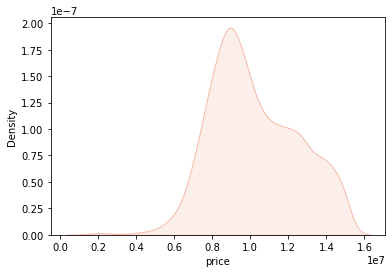

In [15]:
import seaborn as sns 
sns.kdeplot(data=data['price'], color='#F5BCA9', shade=True)

Из графика видно, что большинство квартир в Москве стоят в промежутке 7-12 миллионов рублей, что и предполагалось, исходя из стандартного отклонения. Однако, заметно, что "дорогих" квартир (более 12 миллионов рублей) гораздо больше, чем "дешевых" (менее 7 миллионов рублей).

Построим горизонтальную гистограмму средних цен на квартиру в зависимости от станции метро, к которой близка квартира. Для этого извлечем множество станций метро из признака **subway_station** датасета.

In [16]:
subway_values = list(data['subway_station'].unique())
subway_values

['Новопеределкино',
 'Первомайская',
 'Некрасовка',
 'Селигерская',
 'Улица академика Янгеля',
 'Окская',
 'Свиблово',
 'Бабушкинская',
 'Кузьминки',
 'Перово',
 'Парк Победы',
 'Щукинская',
 'Царицыно',
 'Университет',
 'Рязанский проспект',
 'Стахановская',
 'Шоссе Энтузиастов',
 'Лефортово',
 'Нагатинская',
 'Дмитровская',
 'Измайловская',
 'Щелковская',
 'Алма-Атинская',
 'Юго-Восточная',
 'Кунцевская',
 'Тимирязевская',
 'Ботанический сад',
 'Улица Скобелевская',
 'Крымская',
 'Люблино',
 'Белокаменная',
 'Крылатское',
 'Раменки',
 'Молодежная',
 'Бибирево',
 'Говорово',
 'Пражская',
 'Нагорная',
 'Багратионовская',
 'Коньково',
 'Ховрино',
 'Рассказовка',
 'Балтийская',
 'Пролетарская',
 'Панфиловская',
 'Саларьево',
 'Пятницкое шоссе',
 'Текстильщики',
 'Октябрьское поле',
 'р-н Молжаниновский',
 'Тульская',
 'р-н Куркино',
 'Варшавская',
 'Солнцево',
 'Площадь Гагарина',
 'Коломенская',
 'Тропарево',
 'Шелепиха',
 'Отрадное',
 'Проспект Вернадского',
 'Лихоборы',
 'Белорусская'

In [17]:
from statistics import mean
vals = data[data['subway_station'] == 'Щукинская']
mean(vals['price'].tolist())

11194448.27586207

In [18]:
from statistics import mean
def get_mean(values, column_feature, column_value):
    means = {}
    count = {}
    for val in values:
        temp_df = data[data[column_feature] == val]
        temp_vals = temp_df[column_value].tolist()
        val_mean = mean(temp_vals)
        val_count = len(temp_vals)
        means[val] = round(val_mean, 3)
        count[val] = val_count
    return means, count

In [19]:
mean_dict, count_dict = get_mean(subway_values, 'subway_station', 'price')
sorted_mean_dict = sorted(mean_dict.items(), key=lambda x: x[1])
mean_dict = dict(sorted_mean_dict)
mean_dict

{'Достоевская': 6600000,
 'р-н Южное Бутово': 7237500,
 'р-н Молжаниновский': 7252222.111,
 'р-н Северный': 7593247.103,
 'Румянцево': 7849500,
 'Аннино': 7889464.286,
 'Юго-Восточная': 8058250,
 'Новохохловская': 8172222.222,
 'Рязанский проспект': 8244240.32,
 'Щелковская': 8246029.397,
 'Улица Скобелевская': 8252430,
 'Орехово': 8456850,
 'Некрасовка': 8625608.442,
 'Новоясеневская': 8668250,
 'Улица Горчакова': 8826956.522,
 'Бульвар Дмитрия Донского': 8900000,
 'Отрадное': 8961033.143,
 'Кузьминки': 8970439,
 'Алма-Атинская': 8973192.308,
 'Первомайская': 8993690.625,
 'Боровское шоссе': 9012500,
 'Новогиреево': 9050829.785,
 'Южная': 9053125,
 'Измайловская': 9097142.857,
 'Нахимовский проспект': 9119000,
 'Волжская': 9168090.909,
 'Шипиловская': 9190562.5,
 'Коммунарка': 9233333.333,
 'Текстильщики': 9236299.967,
 'Севастопольская': 9272272.727,
 'Зябликово': 9302500,
 'Сходненская': 9303000,
 'Улица Дмитриевского': 9304444.444,
 'Бульвар адмирала Ушакова': 9333333.333,
 'Бунинс

В итоге, самая низкая средняя цена на квартиру - близ м. Достоевская, а самая высокая средняя цена на квартиру - близ м. Киевская. Единственное, что стоило бы дополнить картину графиком "ящик с усами" для каждой станции метро - ведь большинство станций метро в датасете представлены всего парой квартир, а графики позволили бы дополнить картину.

Большинство квартир в Москве на разных станциях метро имеют среднюю цену в диапазоне 7-12 миллионов рублей, а самые дорогие, как правило, расположены либо близко к центру, либо близко к удобным для пересадок развилкам метро.

In [20]:
import matplotlib.pyplot as plt
def get_plot_info(dictionary):
    x = []
    y = []
    list_dict = list(dictionary.items())
    for val in list_dict:
        x.append(val[0])
        y.append(val[1])
    return x, y
x, y = get_plot_info(mean_dict)
plt.rcParams['font.size'] = '16'
plt.figure(figsize=(30, 50), dpi=250)
plt.grid(alpha=0.6)
plt.barh(x, y, color='#F5BCA9')

<BarContainer object of 209 artists>

#### Зависимость количества объявлений от станции метро

Также построим график зависимости количества квартир от станции метро.

In [21]:
sorted_count_dict = sorted(count_dict.items(), key=lambda x: x[1])
count_dict = dict(sorted_count_dict)
count_dict

{'Достоевская': 1,
 'Фрунзенская': 1,
 'Комсомольская': 1,
 'Угрешская': 1,
 'Охотный ряд': 1,
 'Международная': 1,
 'Пионерская': 1,
 'Филатов луг': 1,
 'Ольховая': 1,
 'Киевская': 1,
 'Добрынинская': 1,
 'Воробьевы Горы': 2,
 'Стрешнево': 2,
 'Сухаревская': 2,
 'Серпуховская': 2,
 'Косино': 2,
 'Бульвар Дмитрия Донского': 2,
 'Румянцево': 2,
 'Лермонтовский проспект': 2,
 'Таганская': 2,
 'Цветной бульвар': 2,
 'Котельники': 2,
 'Ленинский проспект': 2,
 'Краснопресненская': 3,
 'Курская': 3,
 'Кутузовская': 3,
 'Минская': 3,
 'Хорошевская': 3,
 'Черкизовская': 3,
 'Новокузнецкая': 3,
 'Чкаловская': 3,
 'Площадь Ильича': 4,
 'Полежаевская': 4,
 'Павелецкая': 4,
 'Зорге': 4,
 'Измайлово': 4,
 'Владыкино': 4,
 'Красные ворота': 4,
 'Студенческая': 4,
 'р-н Южное Бутово': 4,
 'Технопарк': 4,
 'Выставочная': 4,
 'Шаболовская': 5,
 'Борисово': 5,
 'Спортивная': 5,
 'Каширская': 6,
 'Верхние котлы': 6,
 'Волгоградский проспект': 6,
 'Электрозаводская': 6,
 'Коммунарка': 6,
 'Менделеевская'

In [22]:
x, y = get_plot_info(count_dict)
plt.figure(figsize=(30, 50), dpi=250)
plt.grid(alpha=0.6)
plt.barh(x, y, color='#F5BCA9')

<BarContainer object of 209 artists>

Из графиков можно заметить, что большинство квартир на продаже находятся на окраинах веток метро (м. Щелковская, м. Алтуфьево и т. д.). Самое большое предложение квартир (в 2(!) раза больше, чем "второе место" среди предложений) - на м. Некрасовка. Вероятно, это связано с тем, что метро новое и в связи с этим выросло предложение. 

Почти все станции метро, где количество объявлений выше 25 - крайние станции метро.

#### Зависимость цен в зависимости от удаленности от станции метро

График scatterplot дает мало представлений о распределении цен на квартиры в зависимости от удаленности от станции метро засчет того, что присутствуют явные выбросы данных. Построим график "ящик с усами" для определения диапазона распределения цен и медианы цен в зависимости от удаленности. Разобьем данные на категории "метро в 0-200 м", "метро в 200-600 м", "метро в 600-1000 м", "метро в 1-1,6 км", "метро более чем в 1,6-2,5 км".

In [23]:
data_200 = data[data['to_subway'] < 200]
data_600 = data[(data['to_subway'] < 600) & (data['to_subway'] >= 200)]
data_1000 = data[(data['to_subway'] < 1000) & (data['to_subway'] >= 600)]
data_1600 = data[(data['to_subway'] < 1600) & (data['to_subway'] >= 1000)]
data_2500 = data[(data['to_subway'] < 2500) & (data['to_subway'] >= 1600)]
data_2500_plus = data[data['to_subway'] >= 2500]

<AxesSubplot:>

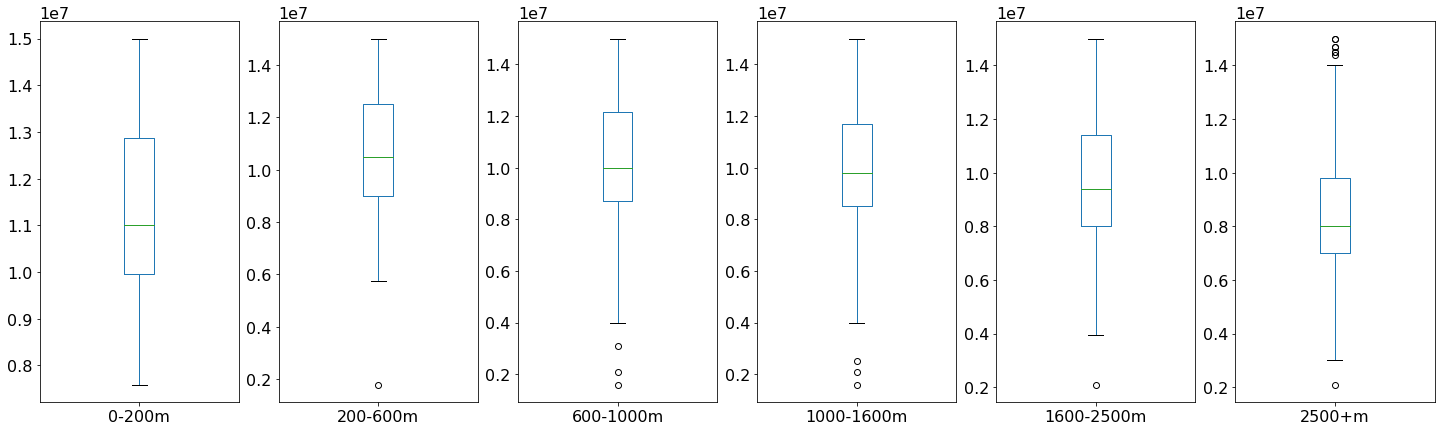

In [24]:
fig, ax = plt.subplots(1,6, figsize=(25,7))
data_200['price'].plot.box(ax=ax[0], label='0-200m')
data_600['price'].plot.box(ax=ax[1], label='200-600m')
data_1000['price'].plot.box(ax=ax[2], label='600-1000m')
data_1600['price'].plot.box(ax=ax[3], label='1000-1600m')
data_2500['price'].plot.box(ax=ax[4], label='1600-2500m')
data_2500_plus['price'].plot.box(ax=ax[5], label='2500+m')

Из графиков заметна тенденция: с увеличением удаленности квартиры от метро падает средняя цена квартиры и нижняя граница стоимости квартиры. При этом верхняя граница остается почти неизменной и находится в районе 14,5-15 миллионов рублей (за исключением случая, когда удаленность от метро составляет более 2,5 км - верхняя граница 99,3% данных в этом случае составляет порядка 14 миллионов рублей).

Что удивительно, в категории "удаленность от метро больше 2,5 км" средняя стоимость квартиры упала на 1 миллион рублей по сравнению с предыдущей категорией и на 3 миллиона рублей по сравнению с категорией "самых близких к метро" квартир, но, тем не менее, присутствует маленький процент квартир, имеющих стоимость, сопоставимую с максимальной. Однако падение цены преимущественно во всех случаях: удаленность от метро значительно "удешевляет" квартиру.

Более точно зависимость цены от удаленности от метро можно рассмотреть на отдельно взятой станции метро. Возьмем станцию м. Некрасовка, которая имеет самое большое количество объявлений, вследствие чего можно более объективно оценивать зависимость.

In [25]:
data_200_n = data[(data['to_subway'] < 200) & (data['subway_station'] == 'Некрасовка')]
data_600_n = data[(data['to_subway'] < 600) & (data['to_subway'] >= 200) & (data['subway_station'] == 'Некрасовка')]
data_1000_n = data[(data['to_subway'] < 1000) & (data['to_subway'] >= 600) & (data['subway_station'] == 'Некрасовка')]
data_1600_n = data[(data['to_subway'] < 1600) & (data['to_subway'] >= 1000) & (data['subway_station'] == 'Некрасовка')]
data_2500_n = data[(data['to_subway'] < 2500) & (data['to_subway'] >= 1600) & (data['subway_station'] == 'Некрасовка')]
data_2500_plus_n = data[(data['to_subway'] >= 2500) & (data['subway_station'] == 'Некрасовка')]

([<matplotlib.patches.Wedge at 0x229e0c099a0>,
 [Text(1.0995931149904536, 0.02991624083322063, '0-200m'),
  Text(0.5238883423811487, 0.9672336867154351, '200-600m'),
  Text(-1.0853837249409135, -0.1787237243160178, '600-1000m'),
  Text(0.007479897500315876, -1.0999745684030084, '1000-1600m'),
  Text(0.7961074335701369, -0.7590869213827691, '1600-2500m'),
  Text(1.0963398407504263, -0.0896602118184523, '2500+ m')],
 [Text(0.5997780627220656, 0.01631794954539307, '1%'),
  Text(0.2857572776624447, 0.5275820109356918, '32%'),
  Text(-0.5920274863314072, -0.09748566780873696, '39%'),
  Text(0.004079944091081386, -0.5999861282198228, '6%'),
  Text(0.4342404183109837, -0.41404741166332854, '19%'),
  Text(0.5980035495002325, -0.04890557008279216, '3%')])

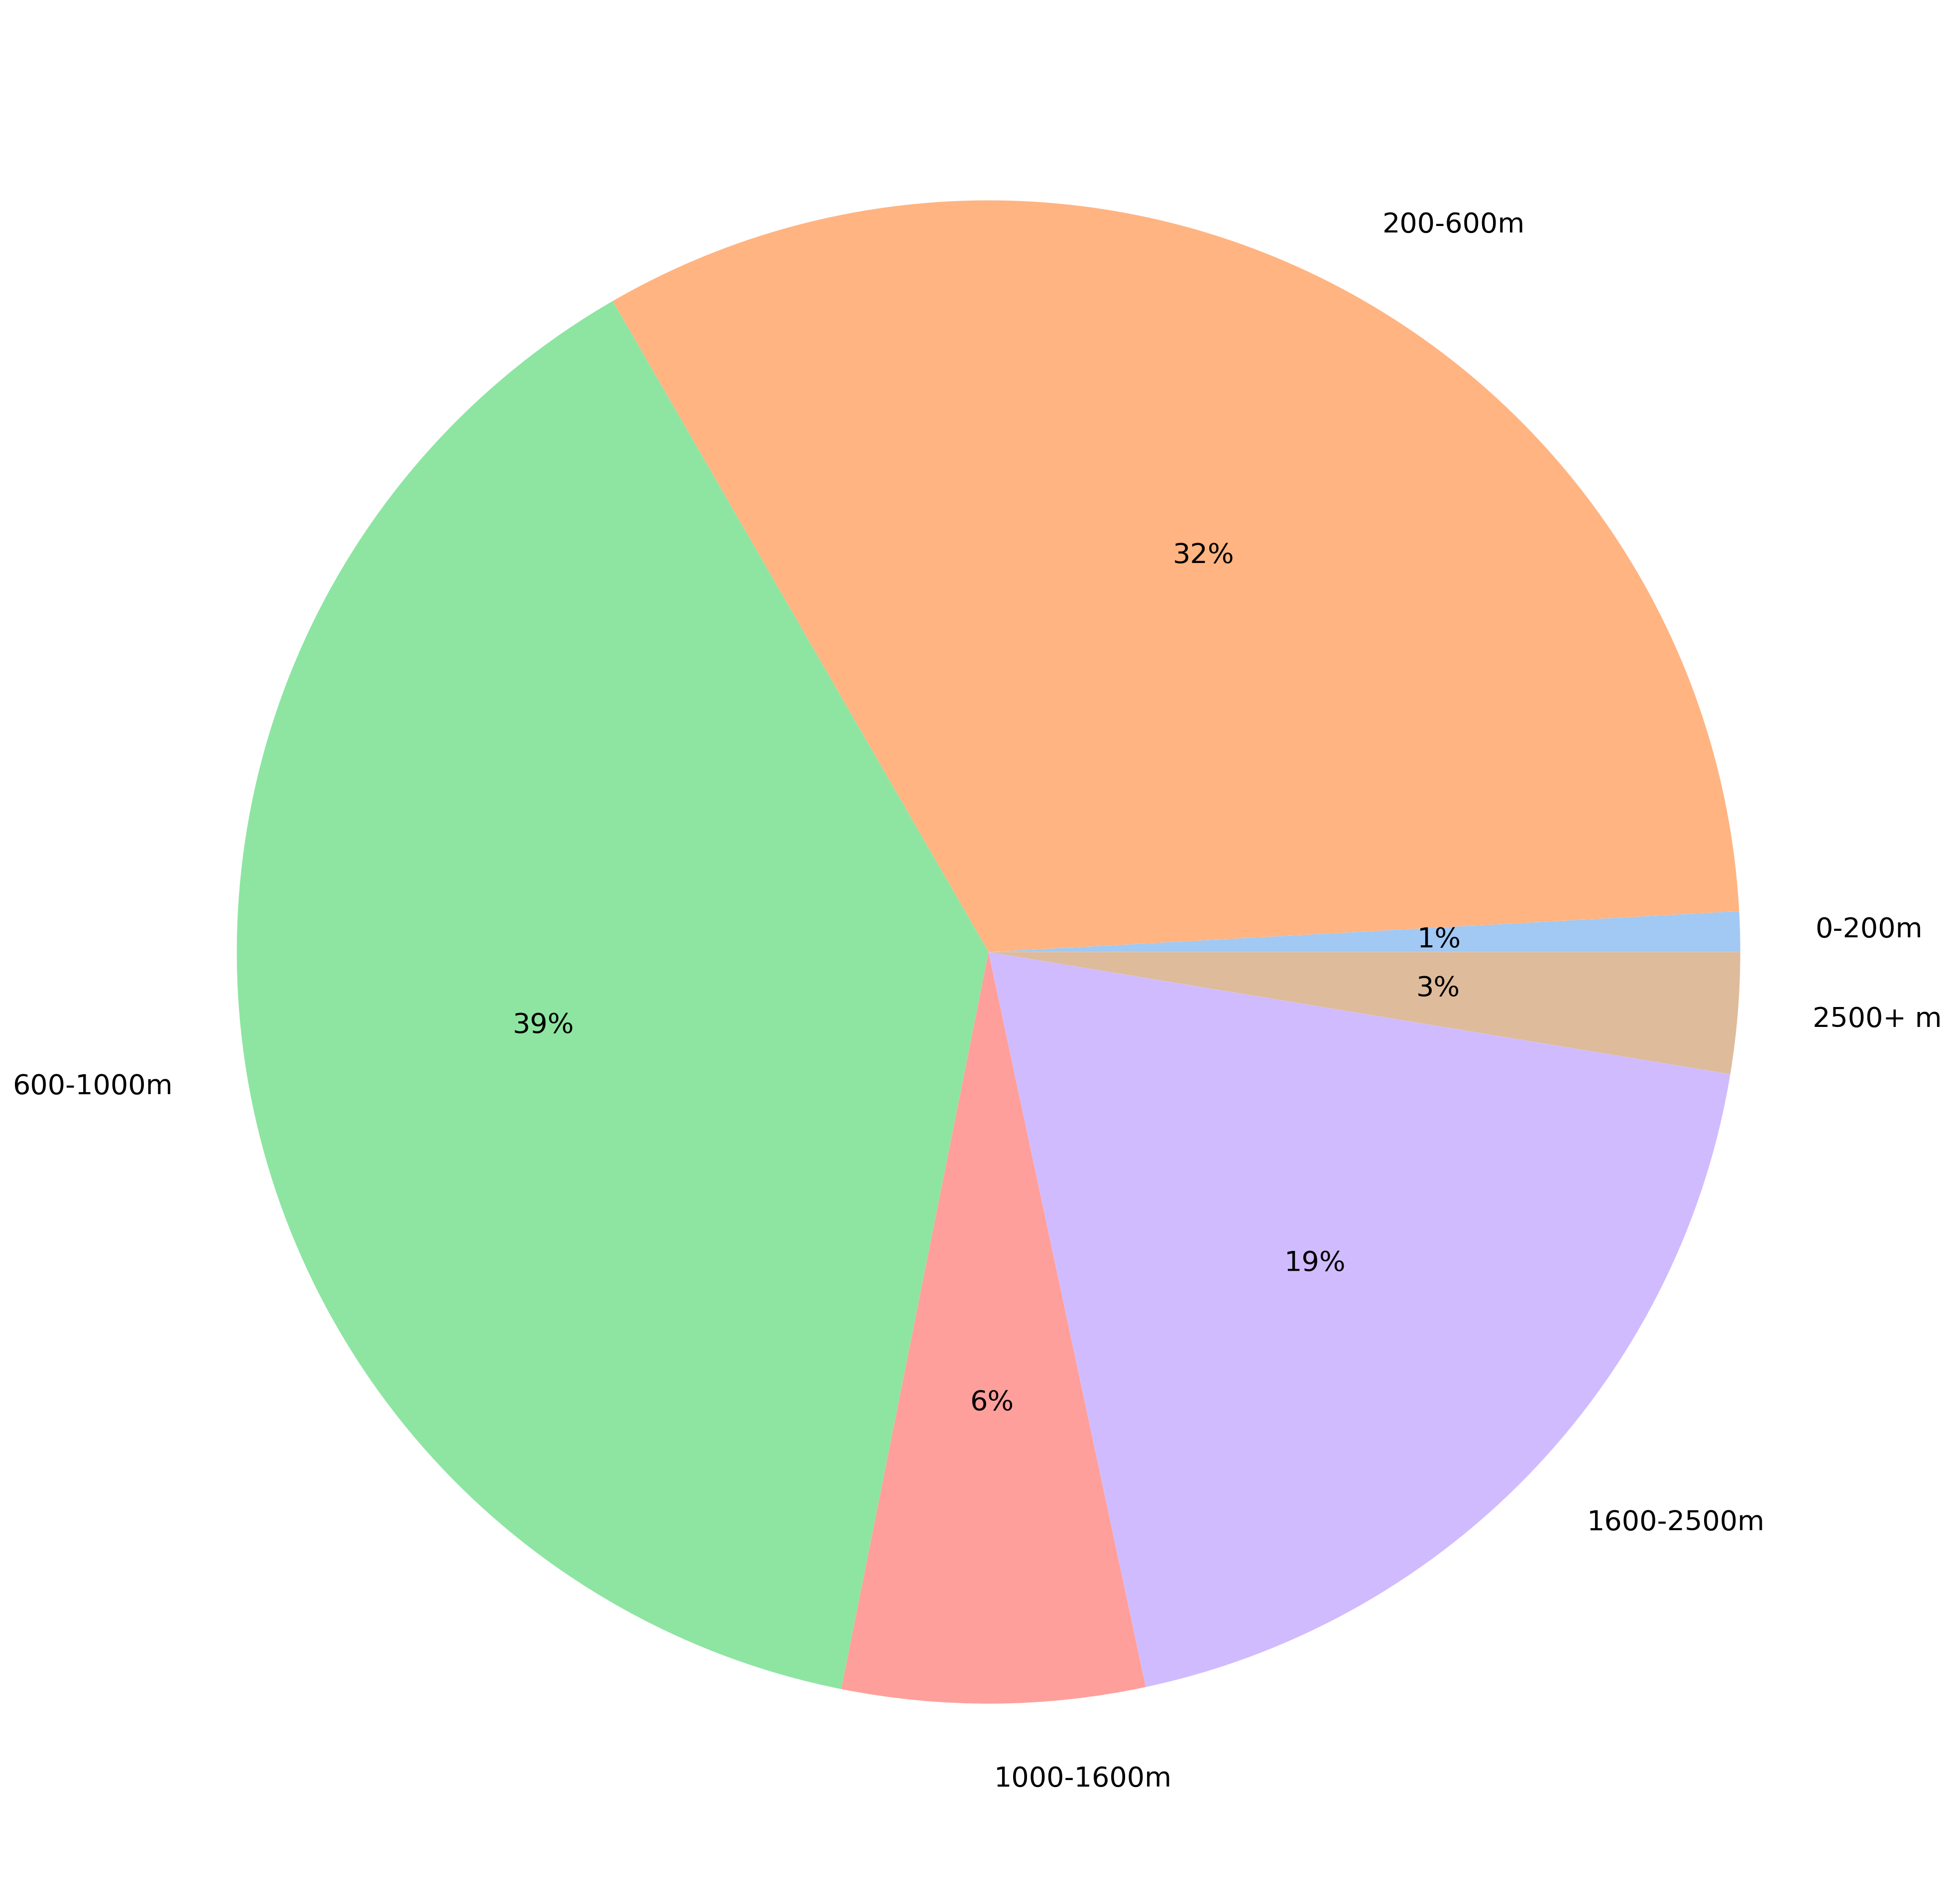

In [26]:
labels = ['0-200m', '200-600m', '600-1000m', '1000-1600m', '1600-2500m', '2500+ m']
data_for_plot = [len(data_200_n), len(data_600_n), len(data_1000_n), len(data_1600_n), len(data_2500_n), len(data_2500_plus_n)]
colors = sns.color_palette('pastel')[0:6]
plt.figure(figsize=(20, 20), dpi=250)
plt.pie(data_for_plot, labels = labels, colors = colors, autopct='%.0f%%')

Из гистограммы видно, что большая часть квартир располагается в 600-1000 м от метро. Для сравнения цен возьмем также категории "200-600 м от метро" и "1600-2500 м от метро", так как процент объявлений на продажу квартир в этих диапазонах удаленности от метро также относительно большой.

<AxesSubplot:>

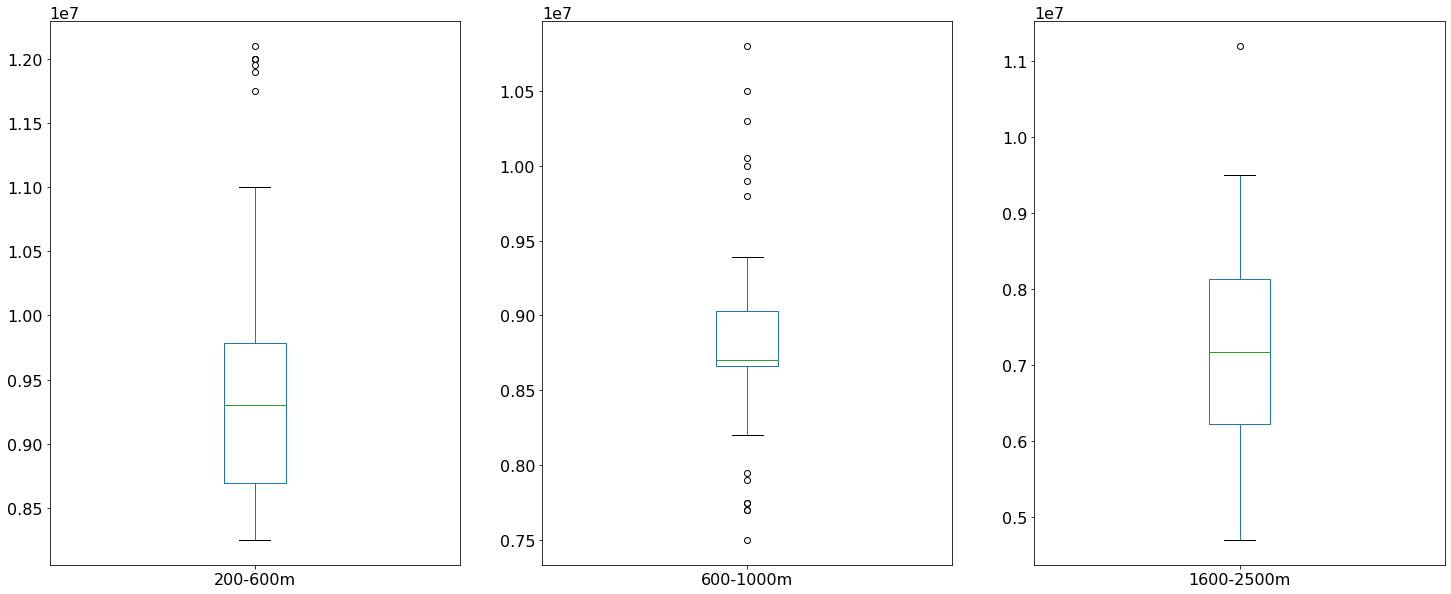

In [27]:
fig, ax = plt.subplots(1,3, figsize=(25,10))
data_600_n['price'].plot.box(ax=ax[0], label='200-600m')
data_1000_n['price'].plot.box(ax=ax[1], label='600-1000m')
data_2500_n['price'].plot.box(ax=ax[2], label='1600-2500m')

Из графиков четко заметно сильное падение средней цены на квартиру (9,3 миллиона рублей для диапазона "200-600 м", 8,7 миллиона рублей для диапазона "600-1000 м", 7,2 миллиона рублей для диапазона "1600-2500 м"). Квартильный размах для графиков цен также заметно сужается с увеличенем удаленности от метро. Для диапазона "600-1000 м" можно наблюдать, что некоторое количество квартир продаются по ценам, сравнимым с диапазоном "200-600 м", но, все же, большинство квартир имеют диапазон цен от 8,3 до 9,3 миллиона рублей, что меньше средней стоимости квартиры ближе к метро.

Сравним квартиры примерно одинаковой стомости для категорий "200-600 м от метро" и "600-1000 м от метро".

In [28]:
data_1000_n[(data_1000_n['price'] >= 0.98e7) & (data_1000_n['price'] < 1e7)]

id    price                            features  \
1586  1606  9900000      2-к квартира, 56 м², 9/19 эт.    
2784  2817  9800000   2-к квартира, 62.8 м², 17/23 эт.    

                                                 street subway_station  \
1586                            Рождественская ул., 16      Некрасовка   
2784   Юго-Восточный административный округ, район Н...     Некрасовка   

      to_subway  
1586      600.0  
2784      700.0

In [29]:
data_600_n[(data_600_n['price'] >= 0.98e7) & (data_600_n['price'] < 1e7)]

id    price                            features  \
1430  1450  9800000      2-к квартира, 65 м², 7/14 эт.    
2126  2152  9900000      2-к квартира, 65 м², 6/17 эт.    
3697  3759  9800000   2-к квартира, 58.9 м², 10/17 эт.    

                             street subway_station  to_subway  
1430        Рождественская ул., 39      Некрасовка      200.0  
2126        Рождественская ул., 37      Некрасовка      200.0  
3697   ул. Ухтомского Ополчения, 1      Некрасовка      300.0

Из сравнения квартир с id=1606 и id=1450, 2152 можно заметить, что квартиры расположены на одной и той же улице и их различиями становятся два фактора: квадратная площадь квартиры и этаж. Возможно, чем выше находится квартира в данном районе, тем она дороже. Однако, странно, что квартира с меньшей площадью и большей удаленностью от станции метро в цене не уступает квартирам с большей площадью и меньшей удаленностью от станции метро. В данном случае не удалось увидеть явную корелляцию признаков.

Из сравнения квартир с id=2817 и id=3759 видно, что удаленность от метро компенсируется большей площадью квартиры.

Для более точного выявления зависимости цены квартиры от ее параметров следует провести дополнительное исследование "цена от площади квартиры" и сравнить эти результаты с предыдущими.

На данный момент можно сказать:<br>
1. Средняя стоимость квартиры в Москве - 10 миллионов рублей. Большинство квартир имеют стоимость от 7 до 12 миллионов рублей.
2. Самое большое количество объявлений на продажу квартиры - рядом с м. Некрасовка. Возможной причиной является то, что открытие нового метро способствовало с увеличению продажи недвижимости.
3. Большое количество объявлений о продаже квартир также и на конечных станциях метро. Это может быть связано как с тем, что фактор удаленности метро от центра понижает спрос, так и наоборот - с тем, что новые квартиры строятся и продаются как раз в более удаленных частях от центра Москвы.
4. Станции метро, располагающиеся ближе к центру (либо являющиеся удобными "развилками" метро для пересадок) обладают самой большой средней стоимостью квартир. Самая большая средняя стоимость квартир - на м. Киевская, м. Международная, м. Фрунзенская.
5. С удаленностью квартиры от ближайшей станции метро падает и ее средняя стоимость. Это связано с логистическим неудобством передвижения по городу. 
6. В результате сравнения квартир, расположенных близко к одной станции метро, выявлено, что на цену квартиры влияет не только удаленность от станции метро, но, возможно, и факторы площади квартиры/этажа. Необходимо провести дополнительное исследование.

#### Оценка 1-к квартир по имеющимся данным

Проведя анализ по зависимости цен от разных факторов, можно попробовать обучить модель для оценки других квартир. Для обучения модели наполним датафрейм новыми столбцами для более полной картины. Для начала, распарсим **features** на площадь квартиры (**square**) и информацию об этажах: этаж квартиры (**floor_current**) и всего этажей в доме (**floor_total**). Можно также попробовать объединить информацию об этажах в одно значение: отношение этажа квартиры к количеству этажей в доме - эта метрика будет показывать "в какой части дома располагается квартира", но это лишь предположение - далее эта метрика не использовалась.

In [30]:
def split_square(column):
    list_data = column.split(',')
    square = float(list_data[1].split()[0])
    return square

def split_floor_current(column):
    list_data = column.split(',')
    floor_temp = list_data[2].split()[0].split('/')
    floor = int(floor_temp[0])
    return floor

def split_floor_total(column):
    list_data = column.split(',')
    floor_temp = list_data[2].split()[0].split('/')
    floor = int(floor_temp[1])
    return floor

def room_amount(column):
    return 2

data_temp = data.copy()
data_temp['square'] = data_temp['features'].apply(split_square)
data_temp['floor_current'] = data_temp['features'].apply(split_floor_current)
data_temp['floor_total'] = data_temp['features'].apply(split_floor_total)
data_temp['room_total'] = data_temp['features'].apply(room_amount)
data_temp

id     price                            features  \
0        0  13700000     2-к квартира, 65 м², 13/25 эт.    
1        1   7912000       2-к квартира, 43 м², 2/5 эт.    
2        2   9390000    2-к квартира, 52.2 м², 4/17 эт.    
3        3   8667975   2-к квартира, 59.3 м², 13/25 эт.    
4        4   9180000   2-к квартира, 58.9 м², 13/17 эт.    
...    ...       ...                                 ...   
4193  4287   8664000    2-к квартира, 65.2 м², 7/25 эт.    
4194  4288   9557050   2-к квартира, 65.4 м², 14/25 эт.    
4195  4289   8667975    2-к квартира, 59.3 м², 5/25 эт.    
4196  4290   8667975    2-к квартира, 59.3 м², 4/25 эт.    
4197  4292  13000000    2-к квартира, 70.3 м², 3/13 эт.    

                        street   subway_station  to_subway  square  \
0           Лукинская ул., 10   Новопеределкино     1300.0    65.0   
1        12-я Парковая ул., 5      Первомайская      900.0    43.0   
2        Покровская ул., 17к2        Некрасовка      600.0    52.2   
3      Рождественская ул., 33        Некрасовка      200.0    59.3   
4           ул. Лавриненко, 1        Некрасовка      800.0    58.9   
...                        ...              ...        ...     ...   
4193     ул. Вертолётчиков, 1        Некрасовка      700.0    65.2   
4194   Рождественская ул., 33        Некрасовка      200.0    65.4   
4195   Рождественская ул., 33        Некрасовка      200.0    59.3   
4196   Рождественская ул., 33        Некрасовка      200.0    59.3   
4197    Варшавское ш., 141к13            Аннино      600.0    70.3   

      floor_current  floor_total  room_total  
0                13           25           2  
1                 2            5           2  
2                 4           17           2  
3                13           25           2  
4                13           17           2  
...             ...          ...         ...  
4193              7           25           2  
4194             14           25           2  
4195              5           25           2  
4196              4           25           2  
4197              3           13           2  

[4198 rows x 10 columns]

Также добавлен столбец **room_total**, который принимает значение 2 в каждой строке: весь датасет составлен для 2-к квартир.

После того, как все признаки были извлечены, категориальный признак **features** удален из датафрейма.

In [31]:
data_temp = data_temp.drop(columns=['features', 'street'], axis=1)

In [32]:
data_temp

id     price   subway_station  to_subway  square  floor_current  \
0        0  13700000  Новопеределкино     1300.0    65.0             13   
1        1   7912000     Первомайская      900.0    43.0              2   
2        2   9390000       Некрасовка      600.0    52.2              4   
3        3   8667975       Некрасовка      200.0    59.3             13   
4        4   9180000       Некрасовка      800.0    58.9             13   
...    ...       ...              ...        ...     ...            ...   
4193  4287   8664000       Некрасовка      700.0    65.2              7   
4194  4288   9557050       Некрасовка      200.0    65.4             14   
4195  4289   8667975       Некрасовка      200.0    59.3              5   
4196  4290   8667975       Некрасовка      200.0    59.3              4   
4197  4292  13000000           Аннино      600.0    70.3              3   

      floor_total  room_total  
0              25           2  
1               5           2  
2              17           2  
3              25           2  
4              17           2  
...           ...         ...  
4193           25           2  
4194           25           2  
4195           25           2  
4196           25           2  
4197           13           2  

[4198 rows x 8 columns]

Однако, в данных все еще присутствует категориальный признак **subway_station**. К сожалению, признак имеет слишком большую вариативность и нельзя заменить его с помощью OrdinalEncoder() или OneHotEncoder(). Удаление признака также ухудшит модель.

Из API HeadHunter был взят json из станций метро и информации о них (ссылка: https://api.hh.ru/metro/1). Можно заменить станции на численную информацию: географическую широту и долготу, что является неплохим выходом в данной ситуации, хоть и с некоторыми допущениями относительно точности расположения станций.

Подгрузим json и распарсим его на нужные величины.

In [33]:
coords = pd.read_json('coords.json')
list_coords = coords['lines'].tolist()
list_coords[0]['stations'][0]

{'id': '8.189',
 'name': 'Новокосино',
 'lat': 55.745113,
 'lng': 37.864052,
 'order': 0}

In [34]:
station_coords = {}
for row in list_coords:
    for station in row['stations']:
        lat_lng = str(station['lat']) + ',' + str(station['lng'])
        station_coords[station['name'].lower()] = lat_lng
station_coords

{'новокосино': '55.745113,37.864052',
 'новогиреево': '55.752237,37.814587',
 'перово': '55.75098,37.78422',
 'шоссе энтузиастов': '55.758633,37.748477',
 'авиамоторная': '55.751933,37.717444',
 'площадь ильича': '55.747115,37.680726',
 'марксистская': '55.740746,37.65604',
 'третьяковская': '55.74073,37.625624',
 'ховрино': '55.8777,37.4877',
 'беломорская': '55.8651,37.4764',
 'речной вокзал': '55.854152,37.476728',
 'водный стадион': '55.838978,37.487515',
 'войковская': '55.818923,37.497791',
 'сокол': '55.805564,37.515245',
 'аэропорт': '55.800441,37.530477',
 'динамо': '55.789704,37.558212',
 'белорусская': '55.775179,37.582303',
 'маяковская': '55.769808,37.596192',
 'тверская': '55.765343,37.603918',
 'театральная': '55.758808,37.61768',
 'новокузнецкая': '55.742391,37.62928',
 'павелецкая': '55.731414,37.636294',
 'автозаводская': '55.70631,37.66314',
 'технопарк': '55.695,37.664167',
 'коломенская': '55.677423,37.663719',
 'каширская': '55.654327,37.647705',
 'кантемировская'

Необходимо учесть, что некоторые станции метро только открылись и информации о них в API не нашлось (таких станций около пяти). Если информация о координатах отсутствует - широте и долготе станции будет ставиться NaN-значение, а позже такие строки будут удалены из датафрейма.

In [35]:
import numpy as np
def add_lat(column):
    if column in station_coords.keys():
        lat_lng = station_coords[column]
        lat = float(lat_lng.split(',')[0])
    else:
        lat = 'NaN'
    return lat

def add_lng(column):
    if column in station_coords.keys():
        lat_lng = station_coords[column]
        lng = float(lat_lng.split(',')[1])
    else:
        lng = np.nan
    return lng

def to_lower(column):
    return column.lower()

data_temp['subway_station'] = data_temp['subway_station'].apply(to_lower)
data_temp['latitude'] = data_temp['subway_station'].apply(add_lat)
data_temp['longtitude'] = data_temp['subway_station'].apply(add_lng)
data_temp

id     price   subway_station  to_subway  square  floor_current  \
0        0  13700000  новопеределкино     1300.0    65.0             13   
1        1   7912000     первомайская      900.0    43.0              2   
2        2   9390000       некрасовка      600.0    52.2              4   
3        3   8667975       некрасовка      200.0    59.3             13   
4        4   9180000       некрасовка      800.0    58.9             13   
...    ...       ...              ...        ...     ...            ...   
4193  4287   8664000       некрасовка      700.0    65.2              7   
4194  4288   9557050       некрасовка      200.0    65.4             14   
4195  4289   8667975       некрасовка      200.0    59.3              5   
4196  4290   8667975       некрасовка      200.0    59.3              4   
4197  4292  13000000           аннино      600.0    70.3              3   

      floor_total  room_total   latitude  longtitude  
0              25           2    55.6385   37.354400  
1               5           2  55.794376   37.799364  
2              17           2    55.7029   37.926400  
3              25           2    55.7029   37.926400  
4              17           2    55.7029   37.926400  
...           ...         ...        ...         ...  
4193           25           2    55.7029   37.926400  
4194           25           2    55.7029   37.926400  
4195           25           2    55.7029   37.926400  
4196           25           2    55.7029   37.926400  
4197           13           2  55.583477   37.596999  

[4198 rows x 10 columns]

Произведем удаление строк с образовавшимися NaN-значениями.

In [36]:
data_temp = data_temp.dropna()
data_temp

id     price   subway_station  to_subway  square  floor_current  \
0        0  13700000  новопеределкино     1300.0    65.0             13   
1        1   7912000     первомайская      900.0    43.0              2   
2        2   9390000       некрасовка      600.0    52.2              4   
3        3   8667975       некрасовка      200.0    59.3             13   
4        4   9180000       некрасовка      800.0    58.9             13   
...    ...       ...              ...        ...     ...            ...   
4193  4287   8664000       некрасовка      700.0    65.2              7   
4194  4288   9557050       некрасовка      200.0    65.4             14   
4195  4289   8667975       некрасовка      200.0    59.3              5   
4196  4290   8667975       некрасовка      200.0    59.3              4   
4197  4292  13000000           аннино      600.0    70.3              3   

      floor_total  room_total   latitude  longtitude  
0              25           2    55.6385   37.354400  
1               5           2  55.794376   37.799364  
2              17           2    55.7029   37.926400  
3              25           2    55.7029   37.926400  
4              17           2    55.7029   37.926400  
...           ...         ...        ...         ...  
4193           25           2    55.7029   37.926400  
4194           25           2    55.7029   37.926400  
4195           25           2    55.7029   37.926400  
4196           25           2    55.7029   37.926400  
4197           13           2  55.583477   37.596999  

[4087 rows x 10 columns]

Всего удалено 111 строк, что приемлемо для датасета, учитывая то, какую ценную числовую информацию мы приобрели взамен. Удалим столбец **subway_staiton**, из которого мы извлекли необходимую информацию и столбец **id**.

In [37]:
data_temp = data_temp.drop(columns=['subway_station'], axis=1)

In [38]:
data_temp = data_temp.drop(columns=['id'], axis=1)

In [39]:
data_temp

price  to_subway  square  floor_current  floor_total  room_total  \
0     13700000     1300.0    65.0             13           25           2   
1      7912000      900.0    43.0              2            5           2   
2      9390000      600.0    52.2              4           17           2   
3      8667975      200.0    59.3             13           25           2   
4      9180000      800.0    58.9             13           17           2   
...        ...        ...     ...            ...          ...         ...   
4193   8664000      700.0    65.2              7           25           2   
4194   9557050      200.0    65.4             14           25           2   
4195   8667975      200.0    59.3              5           25           2   
4196   8667975      200.0    59.3              4           25           2   
4197  13000000      600.0    70.3              3           13           2   

       latitude  longtitude  
0       55.6385   37.354400  
1     55.794376   37.799364  
2       55.7029   37.926400  
3       55.7029   37.926400  
4       55.7029   37.926400  
...         ...         ...  
4193    55.7029   37.926400  
4194    55.7029   37.926400  
4195    55.7029   37.926400  
4196    55.7029   37.926400  
4197  55.583477   37.596999  

[4087 rows x 8 columns]

Однако, широту и долготу нельзя использовать напрямую для модели: все же оценка происходит в пределах Москвы. Поэтому предложено использовать ориентир, привязанный к Москве - центр города. Координаты "центра" города - (55.751244, 37.618423). С помощью пакета geopy.geodesic можно измерить растояние от "центра" до станции метро, что и станет оценкой удаленности от центра города. Добавим столбец **distance** - расстояние от центра города до станции метро.

from geopy.distance import geodesic
moscow_latlng = (55.751244, 37.618423)

In [41]:
def distance_to_center(x):
    latlng = (x['latitude'], x['longtitude'])
    return round(geodesic(moscow_latlng, latlng).meters, 3)

data_temp['distance'] = data_temp.apply(distance_to_center, axis=1)

Цену квартиры можно оценивать как полностью, так и как цену за квадратный метр.

In [42]:
data_temp['price_for_sqmeter'] = round(data_temp['price'] / data_temp['square'], 3)

In [43]:
data_temp

price  to_subway  square  floor_current  floor_total  room_total  \
0     13700000     1300.0    65.0             13           25           2   
1      7912000      900.0    43.0              2            5           2   
2      9390000      600.0    52.2              4           17           2   
3      8667975      200.0    59.3             13           25           2   
4      9180000      800.0    58.9             13           17           2   
...        ...        ...     ...            ...          ...         ...   
4193   8664000      700.0    65.2              7           25           2   
4194   9557050      200.0    65.4             14           25           2   
4195   8667975      200.0    59.3              5           25           2   
4196   8667975      200.0    59.3              4           25           2   
4197  13000000      600.0    70.3              3           13           2   

       latitude  longtitude   distance  price_for_sqmeter  
0       55.6385   37.354400  20813.771         210769.231  
1     55.794376   37.799364  12329.219         184000.000  
2       55.7029   37.926400  20085.347         179885.057  
3       55.7029   37.926400  20085.347         146171.585  
4       55.7029   37.926400  20085.347         155857.385  
...         ...         ...        ...                ...  
4193    55.7029   37.926400  20085.347         132883.436  
4194    55.7029   37.926400  20085.347         146132.263  
4195    55.7029   37.926400  20085.347         146171.585  
4196    55.7029   37.926400  20085.347         146171.585  
4197  55.583477   37.596999  18727.058         184921.764  

[4087 rows x 10 columns]

Выберем признаки для обучения модели и целевой признак - цену. Также разделим выборку на обучающую и валидационную в пропорции 3:1.

In [44]:
from sklearn.model_selection import train_test_split

features = ['to_subway', 'square', 'floor_current', 'floor_total', 'room_total', 'distance']
X = data_temp[features]
y = data_temp.price

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

Обучим модель RandomForestRegressor и посмотрим на метрику ошибки. Метрикой выбрана средняя абсолютная ошибка.

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

rf_model = RandomForestRegressor(n_estimators=2000, random_state=1, max_depth=55, criterion='mse')
rf_model.fit(train_X, train_y)
rf_prediction = rf_model.predict(val_X)
print('Mean Absolute Error:', mean_absolute_error(val_y, rf_prediction))

Mean Absolute Error: 908307.0318217581


Получили относительно неплохую среднюю ошибку, но ее еще можно будет улучшить. Посмотрим, как работает модель на реальном примере. Возьмем реальную 1-к квартиру (https://www.avito.ru/moskva/kvartiry/1-k._kvartira_36m_1226et._2315234539).

Ее цена - 12 950 000 рублей. Характеристики квартиры: м. Авиамоторная (в 700 м), 12/36 эт., 36 $м^2$. Расстояние от центра до м. Авиамоторная:

In [60]:
geodesic(moscow_latlng, (55.751933,37.717444)).meters

6218.237037780909

In [57]:
flat_example = pd.DataFrame({'to_subway': [700],
                            'square': [36],
                            'floor_current': [12],
                            'floor_total': [26],
                            'room_total': [1],
                            'distance': [6218]})
flat_example

to_subway  square  floor_current  floor_total  room_total  distance
0        700      36             12           26           1      6218

Предскажем стоимость квартиры:

In [58]:
example_predict = rf_model.predict(flat_example)
example_predict

array([12983398.866])

Итого: получили предсказанные 12983398 рублей против реальных 12950000 рублей. Конечно, это единичный пример и в идеале проверить ее на небольшой выборке, однако можно сделать выводы, что даже такая MAE уже приемлема для оценки. Но попытаемся улучшить результаты, применив градиентный бустинг.

In [51]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(learning_rate=0.01,
                        max_depth=45,
                        n_estimators=2000,
                        n_jobs=4)
xgb_model.fit(train_X, train_y)
xgb_prediction = xgb_model.predict(val_X)
print('Mean Absolute Error:', mean_absolute_error(val_y, xgb_prediction))

Mean Absolute Error: 905178.3637475538


In [61]:
flat_xgb_predict = xgb_model.predict(flat_example)
flat_xgb_predict

array([13565540.], dtype=float32)

# Открытый вопрос (без использования SQL)

Важными метриками могут быть:
1. Стоимость одного найма (сумма расходов на нанимаемых сотрудников (зарплаты и проч.) / количество нанимаемых сотрудников)
2. Процент приглашений на следующий этап: обычно кандидат сначала делает отклик, а затем его приглашают далее (количество "приглашений" кандидата / количество откликов кандидата)
3. Источник найма (судя по данным из таблицы clickstream - решение может зависеть от площадки, с которой пришел кандидат)
4. Рейтинг вакансии (отклики на вакансию / просмотры вакансии)
5. Стандартные метрики вроде опыта кандидата и зарплатных ожиданий
6. Скорость прохождения воронки найма (от отклика до принятия) - думаю, важная информация мониторинга для работодателя

# Заключение

Думаю, данное тестовое задание было самым трудоемким из всех, что мне довелось решать, но при этом и самым интересным! ;) Датасет в части работы с Python может быть и был "простенько" сделан парсером, но в нем можно закопаться, если копать глубже и глубже - там еще есть на что посмотреть.

Может быть, не все мои суждения корректны и после первых предложений перехочется читать тестовое, но я очень хотел бы услышать всю критику - я люблю прорабатывать ошибки, чтобы не допускать их вновь и вновь!

Спасибо!